In [1]:
#connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/EarlyStopping_for_DIP/

/content/drive/MyDrive/EarlyStopping_for_DIP


In [1]:
import numpy as np
import skimage.metrics
import torch
import torch.optim
import os
from third_party.models import *
from third_party.utils.denoising_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

/home/jleuschn/shared_envs/dip_bayesian_ext/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
buffer_size = 100
patience = 1000
width = 128
lr = 0.01
alg = 'adam'
num_iter = 6000
l1 = False

In [3]:
class EarlyStop():
    def __init__(self, size, patience):
        self.patience = patience
        self.wait_count = 0
        self.best_score = float('inf')
        self.best_epoch = 0
        self.img_collection = []
        self.stop = False
        self.size = size

    def check_stop(self, current, cur_epoch):
      #stop when variance doesn't decrease for consecutive P(patience) times
        if current < self.best_score:
            self.best_score = current
            self.best_epoch = cur_epoch
            self.wait_count = 0
            should_stop = False
        else:
            self.wait_count += 1
            should_stop = self.wait_count >= self.patience
        return should_stop

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

def myMetric(x1, x2):
    return ((x1 - x2) ** 2).sum() / x1.size
    # return (np.abs(x1 - x2)).sum() / x1.size

2.46303776325


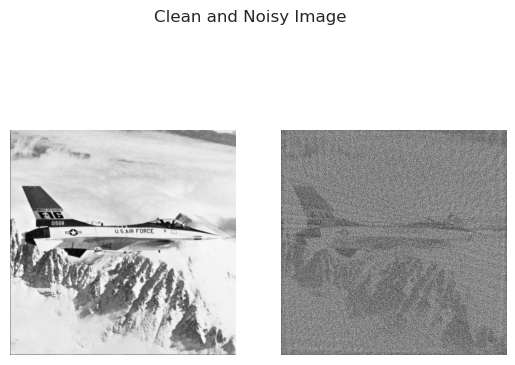

In [4]:
#load image
clean_img = './Dataset/Gaussian_Noise/Clean/F16_clean.npz'
# corrupted_img = './Dataset/Gaussian_Noise/Gaussian_Noise_4/F16_Gaussian_Noise_4.npz'
def rgb2gray(x):
    return np.dot(x, [0.2989, 0.5870, 0.1140])[:, :, None]
raw_img_np = rgb2gray(np.load(clean_img)['arr_0'] / 255.0)
# raw_img_noisy_np = rgb2gray(np.load(corrupted_img)['arr_0'] / 255.0)

import odl
from odl.contrib.torch import OperatorModule

space = odl.uniform_discr(min_pt=[-1.,-1.],max_pt=[1.,1.],shape=raw_img_np.shape[:2],dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=50)

ray_trafo_odl = odl.tomo.RayTransform(space, geometry, impl='astra_cuda')
op = OperatorModule(ray_trafo_odl)

fbp_odl = odl.tomo.fbp_op(ray_trafo_odl)
fbp_op = OperatorModule(fbp_odl)

print(ray_trafo_odl.norm(estimate=True))

rng = np.random.default_rng(1)
noise = rng.normal(0., 0.025, size=ray_trafo_odl.range.shape)
raw_obs_noisy_np = (ray_trafo_odl(raw_img_np.squeeze(2)) + noise).asarray()[:, :, None]
raw_img_noisy_np = fbp_odl(raw_obs_noisy_np.squeeze(2)).asarray()[:, :, None]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clean and Noisy Image')
ax1.imshow(raw_img_np, cmap='gray')
ax2.imshow(raw_img_noisy_np, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.show()
plt.close()

In [5]:
img_np = np.transpose(raw_img_np,(2,0,1))
obs_noisy_np = np.transpose(raw_obs_noisy_np,(2,0,1))
img_noisy_np = np.transpose(raw_img_noisy_np,(2,0,1))
obs_noisy_torch = np_to_torch(obs_noisy_np).type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
# Network (exactly the same as the denoising DIP network, except with tunable width)

input_depth = 32 
n_channels = 1
    
skip_n33d = width 
skip_n33u = width 
skip_n11 = 4
num_scales = 5

net = skip_gn(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales,
                                    num_channels_up =   [skip_n33u]*num_scales,
                                    num_channels_skip = [skip_n11]*num_scales, 
                                    upsample_mode='bilinear', downsample_mode='stride',
                                    need_sigmoid=False, need_bias=True, pad='reflection', act_fun='LeakyReLU').type(dtype) 
    
net_input = get_noise(input_depth, 'noise', (img_np.shape[1], img_np.shape[2])).type(dtype).detach()

# Loss

if l1:
    criterion = torch.nn.L1Loss().type(dtype)
else:
    criterion = torch.nn.MSELoss().type(dtype)

# Optimizer

p = get_params('net', net, net_input)  # network parameters to be optimized

if alg == 'adam':
    optimizer = torch.optim.Adam(p, lr=lr)
elif alg == 'sgd':
    optimizer = torch.optim.SGD(p, lr=lr)
else:
    assert False  

# Optimize

reg_noise_std = 1./30. 
show_every = 1
loss_history = []
psnr_history = []
ssim_history = []
variance_history = []
x_axis = []
earlystop = EarlyStop(size=buffer_size,patience=patience)
def closure(iterator):
    #DIP
    net_input_perturbed = net_input + torch.zeros_like(net_input).normal_(std=reg_noise_std)
    r_img_torch = net(net_input_perturbed)
    r_obs_torch = op(r_img_torch)
    total_loss = criterion(r_obs_torch, obs_noisy_torch)
    total_loss.backward()
    loss_history.append(total_loss.item())
    if iterator % show_every == 0:
        # evaluate recovered image (PSNR, SSIM)
        r_img_np = torch_to_np(r_img_torch)
        psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
        temp_img_np = np.transpose(img_np,(1,2,0))
        temp_r_img_np = np.transpose(r_img_np,(1,2,0))
        ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
        psnr_history.append(psnr)
        ssim_history.append(ssim)

        #variance hisotry
        r_img_np = r_img_np.reshape(-1)
        earlystop.update_img_collection(r_img_np)
        img_collection = earlystop.get_img_collection()
        if len(img_collection) == buffer_size:
            ave_img = np.mean(img_collection,axis = 0)
            variance = []
            for tmp in img_collection:
                variance.append(myMetric(ave_img, tmp))
            cur_var = np.mean(variance)
            cur_epoch = iterator
            variance_history.append(cur_var)
            x_axis.append(cur_epoch)
            if earlystop.stop == False:
                earlystop.stop = earlystop.check_stop(cur_var, cur_epoch)
    return total_loss

In [6]:
for iterator in range(num_iter):
    optimizer.zero_grad()
    closure(iterator)
    optimizer.step()

/tmp/ipykernel_2136916/3450373103.py:63: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
/tmp/ipykernel_2136916/3450373103.py:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
/home/jleuschn/shared_envs/dip_bayesian_ext/lib/python3.10/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


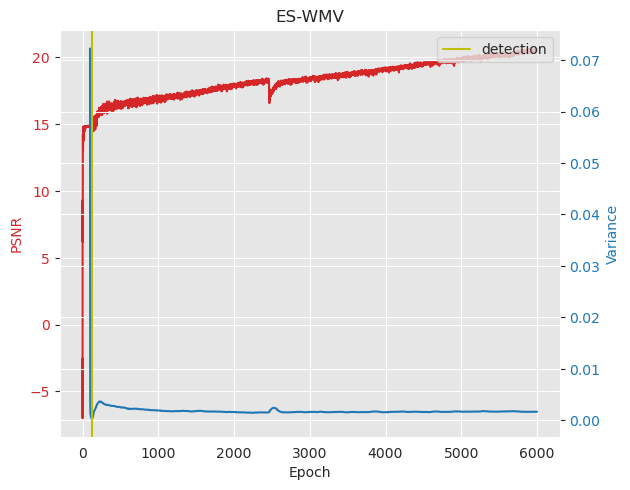

In [7]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(psnr_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, variance_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-WMV')
plt.axvline(x=earlystop.best_epoch, label='detection',color='y')
plt.legend()
plt.show()